# Load data & clean

In [ ]:
!pip install tqdm
!pip install transformers
!pip install LibRecommender

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00


In [ ]:
#install necessary libraries
import re
import json
import pandas as pd
from tqdm import tqdm

In [ ]:
#load data and tranform to pandas dataframe
path_ = '/content/OFFICIAL_CSV_Labeling_dataset_facebook-groups-scraper_raw_SVM_&_FEATURES.csv'

df = pd.read_csv(path_)
# df.head()

## Remove stop words and emojis

In [ ]:
#function to remove emojis from text
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
#remove emojis
df['inputs']=''
for x in tqdm(range(len(df))):
  df['inputs'][x] = remove_emoji(str(df['text'][x]) + '\n' + str(df['title'][x]))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Column1                            1000 non-null   int64  
 1   Supply(Selling)_or_Demand(Buying)  1000 non-null   object 
 2   text                               937 non-null    object 
 3   title                              133 non-null    object 
 4   url                                1000 non-null   object 
 5   legacyId                           1000 non-null   float64
 6   time                               1000 non-null   object 
 7   commentsCount                      1000 non-null   int64  
 8   likesCount                         1000 non-null   int64  
 9   sharesCount                        1000 non-null   int64  
 10  topComments/0/text                 457 non-null    object 
 11  topComments/1/likesCount           189 non-null    float6

## Create Word Embeddings with BERT

In [ ]:
import torch
import random
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords

In [ ]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Input text
word_embeddings_inputs_list = []

# Get English stopwords
stop_words = set(stopwords.words('english'))
for x in tqdm(range(len(df))):
  text = df['inputs'][x]

  # Tokenize text
  tokenized_text = tokenizer.tokenize(text)

  # Filter out stop words
  filtered_tokens = [token for token in tokenized_text if token.lower() not in stop_words]

  # Reconstruct as string text
  cleaned_text = ' '.join(filtered_tokens)

  # Re-Tokenize and encode text with padding and truncation
  inputs = tokenizer(cleaned_text, return_tensors='pt', padding='max_length', truncation=True)

  # Feed input to BERT model to obtain embeddings
  with torch.no_grad():
      outputs = model(**inputs)[0].numpy()
      outputs = np.mean(outputs, axis=1)
      outputs = outputs.flatten()

  # Extract word embeddings
  word_embeddings_inputs_list.append(outputs)

100%|██████████| 1000/1000 [40:38<00:00,  2.44s/it]


# SVM
In this method we classify a post as supply or demand by using Bert Embeddings and using SVM classification model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score

In [ ]:
df['Supply(Selling)_or_Demand(Buying)'].unique()
X = word_embeddings_inputs_list[:310]
y = df.loc[:, ['Supply(Selling)_or_Demand(Buying)']][:310]
y = y.values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=0)

train_indices, test_indices = train_test_split(range(len(X)), test_size=0.10, random_state=0)

In [ ]:
# Classifier - Algorithm - SVM

# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', decision_function_shape='ovr')
SVM.fit(X_train,y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)

# Create a DataFrame containing the test data features and the predicted labels
result_df = pd.DataFrame(data=test_indices)
result_df['Predicted_Labels'] = predictions_SVM

# Print the DataFrame
# print(result_df)

In [ ]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)
# Use precision function to get the precision
print("SVM Precision Score -> ",precision_score(predictions_SVM, y_test, average=None)*100)
# Use F1 function to get the f1 score
print("SVM F1 Score -> ",f1_score(predictions_SVM, y_test, average=None)*100)

SVM Accuracy Score ->  90.32258064516128
SVM Precision Score ->  [100.          92.30769231  50.        ]
SVM F1 Score ->  [66.66666667 96.         66.66666667]


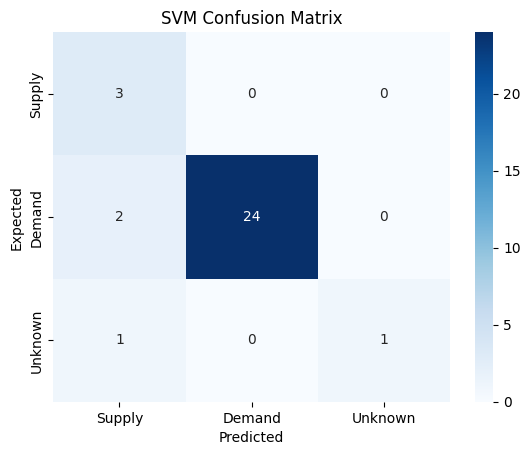

In [ ]:
# Visualize with Confusion Matrix
cm = confusion_matrix(y_test, predictions_SVM)
cm

labels = ['Supply', 'Demand', 'Unknown']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
# Now need to apply svm to everything else

#load data and tranform to pandas dataframe
path_unlabeled = '/content/OFFICIAL_Labeling_dataset_facebook-groups-scraper_raw_UNLABELED.csv'
df_unlabeled = pd.read_csv(path_unlabeled)

#remove emojis
df_unlabeled['inputs']=''
for x in tqdm(range(len(df_unlabeled))):
  df_unlabeled['inputs'][x] = remove_emoji(str(df_unlabeled['text'][x]) + '\n' + str(df_unlabeled['title'][x]))[:512]
df_unlabeled.info()

# Gather Word Embeddings
word_embeddings_inputs_list_unlabeled = []
for x in tqdm(range(len(df_unlabeled))):
  text_unlabeled = df_unlabeled['inputs'][x]
  # Tokenize and encode text
  inputs_unlabeled = tokenizer(text_unlabeled, return_tensors='pt')
  # Feed input to BERT model to obtain embeddings
  with torch.no_grad():
      outputs_unlabeled = model(**inputs_unlabeled)[0].numpy()
      outputs_unlabeled = np.mean(outputs_unlabeled, axis=1)
      outputs_unlabeled = outputs_unlabeled.flatten()
  # Extract word embeddings
  word_embeddings_inputs_list_unlabeled.append(outputs_unlabeled)

# Train test data
X_unlabeled = word_embeddings_inputs_list_unlabeled
y_unlabeled = df_unlabeled.loc[:, ['Supply(Selling)_or_Demand(Buying)']]
y_unlabeled = y_unlabeled.values.ravel()

indices_unlabeled = range(len(X_unlabeled))

predictions_SVM_unlabeled = SVM.predict(X_unlabeled)
# Create a DataFrame containing the test data features and the predicted labels
result_df_unlabeled = pd.DataFrame(data=df_unlabeled['inputs'])
result_df_unlabeled['Predicted_Labels'] = predictions_SVM_unlabeled
df_unlabeled['Supply(Selling)_or_Demand(Buying)'] = result_df_unlabeled['Predicted_Labels']

In [ ]:
# Create a DataFrame containing the test data features and the predicted labels
result_df_unlabeled = pd.DataFrame(data=df_unlabeled['inputs'])
result_df_unlabeled['Predicted_Labels'] = predictions_SVM_unlabeled
df_unlabeled['Supply(Selling)_or_Demand(Buying)'] = result_df_unlabeled['Predicted_Labels']

In [ ]:
final_supply_demand_combined_df = pd.concat([df, df_unlabeled])
final_supply_demand_combined_df = final_supply_demand_combined_df.reset_index(drop=True)
final_supply_demand_combined_df.info()

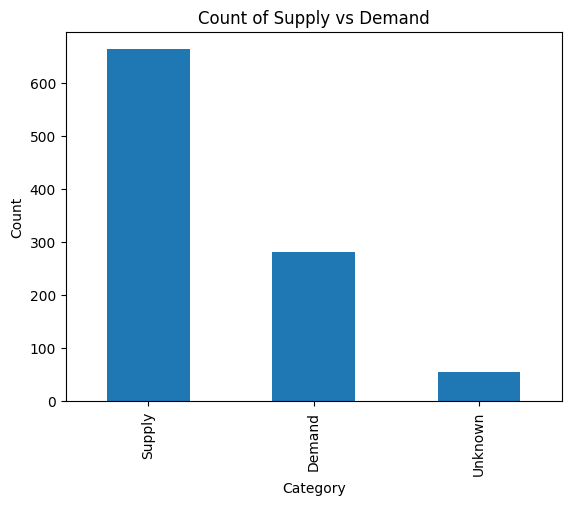

In [ ]:
# Visualize Data
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in the 'Category' column
classify_counts = df['Supply(Selling)_or_Demand(Buying)'].value_counts()

# Create a bar plot
classify_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Supply vs Demand')

# Display the bar chart
plt.show()

In [ ]:
final_supply_demand_combined_df.to_csv('OFFICIAL_Labeling_dataset_facebook-groups-scraper_raw_SVM_PREDICTIONS.csv', index=True)

# Recommendations

## Data prep


In [52]:
# Combine word embedding
# concatenated_word_embeddings_input_list = word_embeddings_inputs_list + word_embeddings_inputs_list_unlabeled
concatenated_word_embeddings_input_list = word_embeddings_inputs_list
print(len(concatenated_word_embeddings_input_list))

1000


In [53]:
#seperate only supply listings & embeddings
columns = ['Column1', 'Supply(Selling)_or_Demand(Buying)', 'text', 'title', 'url',
       'legacyId', 'time', 'commentsCount', 'likesCount', 'sharesCount',
       'topComments/0/text', 'topComments/1/likesCount', 'topComments/1/text',
       'user/id', 'user/name', 'inputs', 'token', 'clean_tokens', 'clean_text',
       'rent', 'location', 'fromDate', 'toDate', 'bedrooms', 'bathrooms',
       'amenities']

df_supply_only = pd.DataFrame(columns=columns, data=[])
df_demand_only = pd.DataFrame(columns=columns, data=[])

concatenated_word_embeddings_input_list__supply_only = {"Index":[], "Embeddings":[]}
concatenated_word_embeddings_input_list__demand_only = {"Index":[], "Embeddings":[]}

label = ""
count = 0

for x in tqdm(range(len(df))):
  label = df['Supply(Selling)_or_Demand(Buying)'].loc[x]
  if label == "Supply":
    df_supply_only.loc[x] = df.loc[x]
    concatenated_word_embeddings_input_list__supply_only['Index'].append(count)
    concatenated_word_embeddings_input_list__supply_only['Embeddings'].append(concatenated_word_embeddings_input_list[x])
  elif label == "Demand":
    df_demand_only.loc[x] = df.loc[x]
    concatenated_word_embeddings_input_list__demand_only['Index'].append(count)
    concatenated_word_embeddings_input_list__demand_only['Embeddings'].append(concatenated_word_embeddings_input_list[x])
  count += 1



100%|██████████| 1000/1000 [00:20<00:00, 47.96it/s]


In [54]:
print(f'length of demand embeddings: {len(concatenated_word_embeddings_input_list__demand_only)}')
print(f'length of supply embeddings: {len(concatenated_word_embeddings_input_list__supply_only)}')

length of demand embeddings: 2
length of supply embeddings: 2


## Using NCF

In [61]:
from datetime import datetime
from libreco.algorithms import NCF
from libreco.evaluation import evaluate
from libreco.data import random_split, DatasetPure
from sklearn.metrics.pairwise import cosine_similarity

Instructions for updating:
non-resource variables are not supported in the long term


In [62]:
# Calculate cosine similarity
cosine_sim_matrix_ncf = cosine_similarity(concatenated_word_embeddings_input_list__supply_only['Embeddings'], concatenated_word_embeddings_input_list__demand_only['Embeddings'])

print("Matrix: ", cosine_sim_matrix_ncf)
print("\nShape: " , cosine_sim_matrix_ncf.shape)

Matrix:  [[0.8691945  0.8539269  0.83642197 ... 0.85505503 0.8570573  0.8507007 ]
 [0.8315415  0.77875054 0.7967556  ... 0.86676997 0.8921507  0.8282633 ]
 [0.90948915 0.8484014  0.83388853 ... 0.89735776 0.93552953 0.8895369 ]
 ...
 [0.32724398 0.31273118 0.3320089  ... 0.40443704 0.41629395 0.3607334 ]
 [0.91190237 0.8846235  0.8580936  ... 0.9137734  0.934332   0.90964174]
 [0.90301186 0.87021786 0.8536538  ... 0.91061187 0.9133531  0.8904521 ]]

Shape:  (664, 281)


In [63]:
# Convert matrix to DataFrame
df_matrix = pd.DataFrame(cosine_sim_matrix_ncf)
# print(df_matrix)

In [64]:
df_matrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,...,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000
mean,0.882988,0.851784,0.850596,0.865426,0.827285,0.871752,0.835645,0.882708,0.868726,0.852489,...,0.805749,0.854815,0.816479,0.881976,0.830085,0.872977,0.893391,0.891041,0.904239,0.880487
std,0.066937,0.068933,0.067135,0.063132,0.075302,0.071434,0.067120,0.064254,0.068621,0.066931,...,0.070872,0.069103,0.073709,0.067996,0.064389,0.070295,0.056799,0.058497,0.057200,0.064354
min,0.327244,0.312731,0.332009,0.371674,0.238370,0.273608,0.294695,0.339833,0.297393,0.288221,...,0.274388,0.268090,0.257934,0.331316,0.346129,0.262466,0.430742,0.404437,0.416294,0.360733
25%,0.868440,0.833835,0.832645,0.851942,0.805154,0.862102,0.821700,0.874012,0.860281,0.843503,...,0.785028,0.847733,0.790503,0.868662,0.805523,0.865172,0.886982,0.885922,0.902674,0.870473
50%,0.899027,0.864399,0.861258,0.878589,0.841606,0.890350,0.850681,0.896994,0.886092,0.868596,...,0.816253,0.870345,0.828278,0.897708,0.839315,0.891247,0.905182,0.904392,0.918276,0.894428
75%,0.918668,0.891124,0.890722,0.900315,0.873124,0.908259,0.871905,0.916455,0.904043,0.885051,...,0.847714,0.890444,0.859526,0.919357,0.870178,0.906935,0.923242,0.920026,0.932369,0.914795
max,0.959838,0.937265,0.934112,0.947744,0.944812,0.936499,0.917001,0.944820,0.938470,0.921623,...,0.927635,0.944830,0.922969,0.954048,0.942342,0.944092,0.957022,0.953991,0.969614,0.956046


In [66]:
# Build the final NCF inputs df using demand and supply word embeddings

# final_ncf_input_df = pd.DataFrame(columns=['demand_id', 'supply_id', 'similarity_score'])
final_ncf_input_df = pd.DataFrame(columns=['user', 'item', 'label'])
count = 0
for x in tqdm(range(len(concatenated_word_embeddings_input_list__demand_only['Index']))):
  for y in range(len(concatenated_word_embeddings_input_list__supply_only['Index'])):
    demand_id = concatenated_word_embeddings_input_list__demand_only['Index'][x]
    supply_id = concatenated_word_embeddings_input_list__supply_only['Index'][y]
    similarity_score = df_matrix[x][y]
    new_row_data = {'user': demand_id, 'item': supply_id, 'label': similarity_score}
    final_ncf_input_df.loc[len(final_ncf_input_df)] = new_row_data
    count += 1

print(final_ncf_input_df)

100%|██████████| 281/281 [14:46<00:00,  3.16s/it]

        user  item     label
0          2     0  0.869195
1          2     1  0.831541
2          2     3  0.909489
3          2     4  0.848354
4          2     6  0.940701
...      ...   ...       ...
186579   996   991  0.882279
186580   996   994  0.800923
186581   996   995  0.360733
186582   996   997  0.909642
186583   996   998  0.890452

[186584 rows x 3 columns]


In [67]:
# convert NCF dataframe to CSV for future use
final_ncf_input_df.to_csv('final_ncf_input_df.csv', index=True)

In [68]:
# split NCF df to train/test
train_data, eval_data, test_data = random_split(final_ncf_input_df, multi_ratios=[0.8, 0.1, 0.1])

In [69]:
# convert NCF dataframe into compatible datatype for LibRecommender
train_data, data_info= DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [70]:
# configure the NCF model
ncf = NCF(
    task="rating",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=16,
    n_epochs=10,
    lr=0.01,
    batch_size=2048,
    num_neg=1,
)

In [81]:
# Train the NCF model
# monitor metrics on eval data during training
ncf.fit(
    train_data,
    neg_sampling=False, #for rating, this param is false else True
    verbose=2,
    eval_data=eval_data,
    metrics=["loss", "rmse", "mae"],
)

metrics = evaluate(
  model=ncf,
  data=test_data,
  neg_sampling=False,
  metrics=["loss", "rmse", "mae"],
)

Training start time: 2024-05-04 04:12:44


train: 100%|██████████| 146/146 [00:02<00:00, 68.38it/s]


Epoch 1 elapsed: 2.148s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 45.97it/s]


	 eval rmse: 0.0086
	 eval rmse: 0.0086
	 eval mae: 0.0068


train: 100%|██████████| 146/146 [00:02<00:00, 64.69it/s]


Epoch 2 elapsed: 2.288s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 38.33it/s]


	 eval rmse: 0.0081
	 eval rmse: 0.0081
	 eval mae: 0.0061


train: 100%|██████████| 146/146 [00:02<00:00, 54.46it/s]


Epoch 3 elapsed: 2.688s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


	 eval rmse: 0.0076
	 eval rmse: 0.0076
	 eval mae: 0.0058


train: 100%|██████████| 146/146 [00:03<00:00, 44.67it/s]


Epoch 4 elapsed: 3.279s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 35.18it/s]


	 eval rmse: 0.0075
	 eval rmse: 0.0075
	 eval mae: 0.0057


train: 100%|██████████| 146/146 [00:02<00:00, 59.28it/s]


Epoch 5 elapsed: 2.474s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 39.57it/s]


	 eval rmse: 0.0124
	 eval rmse: 0.0124
	 eval mae: 0.0106


train: 100%|██████████| 146/146 [00:03<00:00, 48.10it/s]


Epoch 6 elapsed: 3.055s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 27.37it/s]


	 eval rmse: 0.0073
	 eval rmse: 0.0073
	 eval mae: 0.0056


train: 100%|██████████| 146/146 [00:03<00:00, 48.10it/s]


Epoch 7 elapsed: 3.049s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 36.07it/s]


	 eval rmse: 0.0077
	 eval rmse: 0.0077
	 eval mae: 0.0059


train: 100%|██████████| 146/146 [00:03<00:00, 39.79it/s]


Epoch 8 elapsed: 3.683s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 32.98it/s]


	 eval rmse: 0.0071
	 eval rmse: 0.0071
	 eval mae: 0.0054


train: 100%|██████████| 146/146 [00:02<00:00, 51.75it/s]


Epoch 9 elapsed: 2.845s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 51.00it/s]


	 eval rmse: 0.0089
	 eval rmse: 0.0089
	 eval mae: 0.0068


train: 100%|██████████| 146/146 [00:02<00:00, 68.42it/s]


Epoch 10 elapsed: 2.156s
	 train_loss: 0.0001


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 52.28it/s]


	 eval rmse: 0.0081
	 eval rmse: 0.0081
	 eval mae: 0.0062


eval_pointwise: 100%|██████████| 3/3 [00:00<00:00, 70.41it/s]


### Analyze Performance

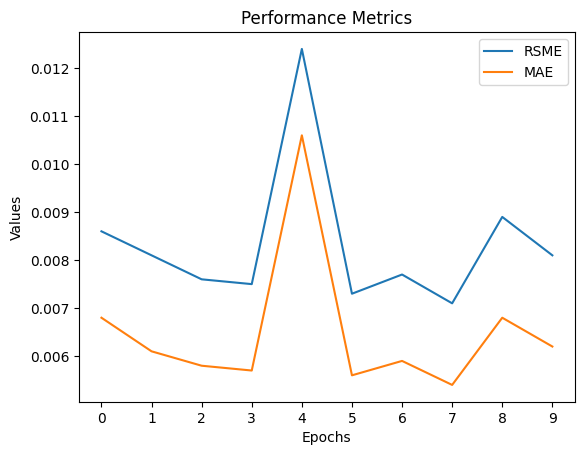

In [113]:
rsme = [0.0086, 0.0081, 0.0076, 0.0075, 0.0124, 0.0073, 0.0077, 0.0071, 0.0089, 0.0081]
mae = [0.0068, 0.0061, 0.0058, 0.0057, 0.0106, 0.0056, 0.0059, 0.0054, 0.0068, 0.0062]

# Plot evaluation metrics
plt.plot(range(10), rsme, label='RSME')
plt.plot(range(10), mae, label='MAE')

plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Performance Metrics')
plt.legend()
plt.xticks(range(0, len(mae)))
plt.show()

In [114]:
print(metrics)

{'loss': 0.007925142, 'rmse': 0.007925142, 'mae': 0.0060948743}


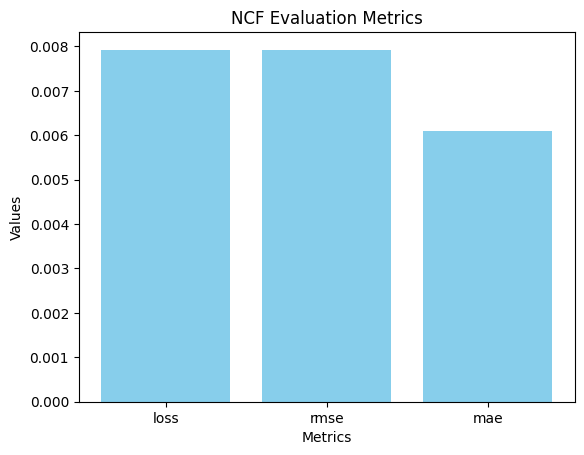

In [93]:
# Extract metric name and values
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plot the metrics
plt.bar(metric_names, metric_values, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('NCF Evaluation Metrics')
plt.show()

In [115]:
# info regarding the data
ncf.data_info

n_users: 281, n_items: 664, data density: 79.9994 %

In [116]:
# identify the IDs for the user/demand posts
final_ncf_input_df['user'].unique()

array([  2,   7,  11,  12,  13,  18,  25,  26,  33,  41,  46,  55,  56,
        63,  69,  72,  78,  81,  83,  89, 156, 158, 167, 173, 181, 182,
       205, 209, 214, 227, 229, 261, 274, 286, 287, 290, 293, 297, 312,
       321, 324, 333, 335, 339, 344, 352, 353, 354, 357, 358, 367, 370,
       374, 380, 382, 399, 400, 401, 404, 405, 407, 410, 411, 415, 417,
       418, 420, 427, 429, 431, 435, 440, 442, 448, 450, 453, 459, 460,
       461, 462, 463, 466, 468, 470, 471, 472, 473, 474, 476, 478, 481,
       482, 483, 486, 487, 495, 496, 497, 498, 499, 503, 506, 507, 511,
       513, 514, 520, 522, 524, 528, 529, 532, 534, 541, 542, 543, 549,
       550, 552, 553, 554, 555, 557, 560, 561, 563, 564, 567, 569, 577,
       580, 584, 591, 592, 596, 597, 600, 602, 605, 607, 613, 621, 631,
       632, 640, 642, 643, 645, 646, 651, 654, 656, 660, 666, 670, 673,
       677, 680, 683, 685, 686, 691, 692, 694, 696, 697, 698, 700, 703,
       704, 705, 707, 712, 716, 719, 720, 722, 727, 729, 731, 73

In [117]:
# # predict preference of user to item
# ncf.predict(user=88, item=11)


# recommend 5 items for user
user_id = 26
top_5_recs_ncf = ncf.recommend_user(user=user_id, n_rec=5)
top_5_recs_ncf

{26: array([307, 310, 377,  88, 574])}

In [118]:
print(df['inputs'].loc[user_id])
print(df['fromDate'].loc[user_id])

Hi everyone, I'm looking for a private room with private bath in the North SJ, North Sunnyvale, Milpitas, or south Fremont area. My budget is $1500.
Let me know if you have anything available!
nan
04/27/2024


In [100]:
for x in top_5_recs_ncf[user_id]:
  print('Seller:', x,'\n' , df['inputs'].loc[x])
  print('DATES:', df['fromDate'].loc[x])
  print("_______________________________________________________________________________________________")

Seller: 307 
 Avaialble now, unit within walking distance (3 blocks) to Sjsu. Own bedroom, bathroom, kitchen and living/dining.  1 designated parking spot. Inhouse laundry. Up to 3 people ok. $2150/mo. 

Pls comment below and send pm to me. I have pics and show you in person (by appointment only).  Thank you.
nan
DATES: 4/27/2024
_______________________________________________________________________________________________
Seller: 310 
 Have a spacious furnished room in a 2b 2b double master condo on 4th st at the Paseo plaza condos rent is $1700 utilities about 200 a month available end of September. Send me a message if interested.
nan
DATES: 09/27/2024
_______________________________________________________________________________________________
Seller: 377 
 Masterbedroom (unfurnished) with private bathroom for rent after October 1 (somewhat flexible). $1900/month. Large backyard, garage space, washer/drier in house, very quiet neighborhood. Located in Santa Clara near Bowers Par